In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter

In [2]:
# The following coefficients correspond to stable poles
coefs_ar_1 = [-0.27002517200218096]
coefs_ar_2 = [0.4511170798064709, -0.05740081602446657]
coefs_ar_5 = [0.10699399235785655, -0.5237303489793305, 0.3068897071844715, -0.17232255282458891, 0.13323964347539288];

In [3]:
function generateAR(num::Int, coefs::Vector{Float64}; variance=1.0)
    order = length(coefs)
    inits = randn(order)
    data = Vector{Vector{Float64}}(undef, num+3*order)
    data[1] = inits
    for i in 2:num+3*order
        data[i] = insert!(data[i-1][1:end-1], 1, rand(Distributions.Normal(coefs'data[i-1], sqrt(variance[])), 1)[1])
    end
    data = data[1+3*order:end]
    return data
end

generateAR (generic function with 1 method)

In [4]:
@model function lar_model_multivariate(n, order, c, stype)
    x = randomvar(n)
    y = datavar(Float64, n)
    
    γ  ~ GammaShapeRate(1.0, 1.0) where { q = MeanField() }
    θ  ~ MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)) where { q = MeanField() }
    x0 ~ MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)) where { q = MeanField() }
    
    ct  = constvar(c)
    γ_y = constvar(1.0)
    
    x_prev = x0
    
    meta = ARMeta(Multivariate, order, stype)
    
    for i in 1:n
        x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = meta }
        y[i] ~ NormalMeanPrecision(dot(ct, x[i]), γ_y) where { q = MeanField() }
        x_prev = x[i]
    end
    
    return x, y, θ, γ
end

lar_model_multivariate (generic function with 1 method)

In [5]:
@model function lar_model_univariate(n, order, c, stype)
    x = randomvar(n)
    y = datavar(Float64, n)
    
    γ  ~ GammaShapeRate(1.0, 1.0) where { q = MeanField() }
    θ  ~ NormalMeanPrecision(0.0, 1.0) where { q = MeanField() }
    x0 ~ NormalMeanPrecision(0.0, 1.0) where { q = MeanField() }
    
    γ_y = constvar(1.0)
    
    x_prev = x0
    
    meta = ARMeta(Univariate, order, stype)
    
    for i in 1:n
        x[i] ~ AR(x_prev, θ, γ) where { q = q(y, x)q(γ)q(θ), meta = meta }
        y[i] ~ NormalMeanPrecision(x[i], γ_y) where { q = MeanField() }
        x_prev = x[i]
    end
    
    return x, y, θ, γ
end

lar_model_univariate (generic function with 1 method)

In [6]:
using BenchmarkTools

In [7]:
lar_model(::Type{ Multivariate }, n, order, c, stype) = lar_model_multivariate(n, order, c, stype)
lar_model(::Type{ Univariate }, n, order, c, stype)   = lar_model_univariate(n, order, c, stype)

lar_model (generic function with 2 methods)

In [8]:
function init_marginals(::Type{ Multivariate }, order, γ, θ)
    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(order), Matrix{Float64}(I, order, order)))
end

function init_marginals(::Type{ Univariate }, order, γ, θ)
    setmarginal!(γ, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, NormalMeanPrecision(0.0, 1.0))
end

init_marginals (generic function with 2 methods)

In [9]:
function inference(data, order, artype, stype, niter)
    n = length(data)
    
    c = ReactiveMP.ar_unit(artype, order)
    
    model, (x, y, θ, γ) = lar_model(artype, n, order, c, stype)
    
    γ_buffer = nothing
    θ_buffer = nothing
    x_buffer = Vector{Marginal}(undef, n)
    
    fe = Vector{Float64}()
    
    γsub = subscribe!(getmarginal(γ), (mγ) -> γ_buffer = mγ)
    θsub = subscribe!(getmarginal(θ), (mθ) -> θ_buffer = mθ)
    xsub = subscribe!(getmarginals(x), (mx) -> copyto!(x_buffer, mx))
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), (f) -> push!(fe, f))
    
    init_marginals(artype, order, γ, θ)
    
    ProgressMeter.@showprogress for i in 1:niter
        update!(y, data)
    end
    
    unsubscribe!(γsub)
    unsubscribe!(θsub)
    unsubscribe!(xsub)
    unsubscribe!(fesub)
    
    return γ_buffer, θ_buffer, x_buffer, fe
end

inference (generic function with 1 method)

In [10]:
using Random
Random.seed!(42)
n = 100

coefs = coefs_ar_2 # coefs_ar_1, coefs_ar_2, coefs_ar_5
gen_ar_order = length(coefs)
data = generateAR(n, coefs)
hidden_states =  first.(data)
observations = hidden_states .+ randn(length(hidden_states));

In [11]:
# Univariate AR
ar_order = 1
γ, θ, xs, fe = inference(observations, ar_order, Univariate, ARsafe(), 100);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [12]:
# Multivariate AR
ar_order = gen_ar_order
γ, θ, xs, fe = inference(observations, ar_order, Multivariate, ARsafe(), 100);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


In [13]:
# Extract inferred parameters
mx, vx = mean.(xs), cov.(xs)
mx = first.(mx)
vx = first.(vx)
mθ = mean(θ)
vθ = cov(θ)
mγ = mean(γ);

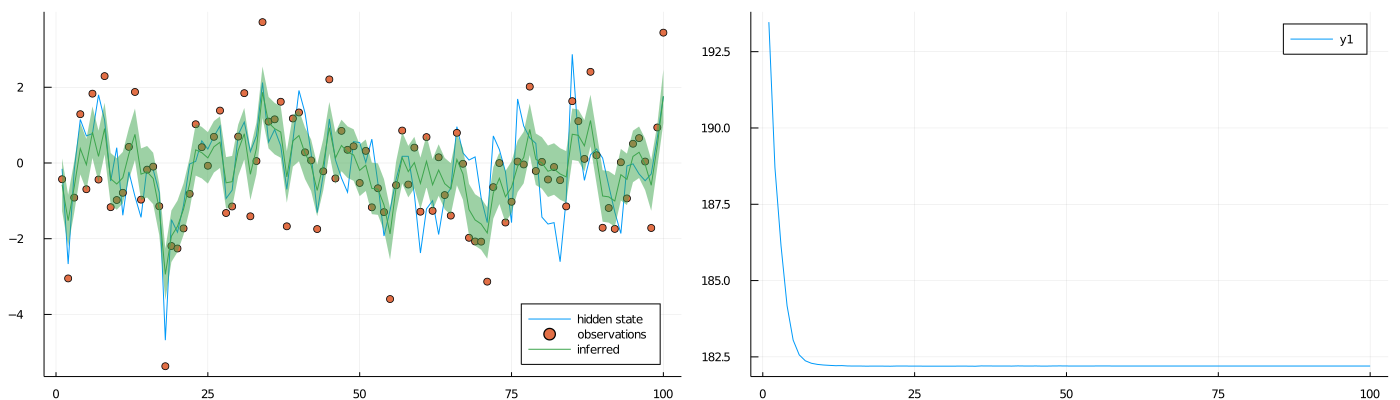

In [14]:
using Plots
p1 = plot(hidden_states, label="hidden state")
p1 = scatter!(p1, observations, label="observations")
p1 = plot!(p1, mx, ribbon = sqrt.(vx), label="inferred", legend=:bottomright)

p2 = plot(fe)

plot(p1, p2, size = (1400, 400))